In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [2]:
data = spec1d.Spec1d('../B0712_lens_spec.txt') 


Reading spectrum from ../B0712_lens_spec.txt
Expected file format: text
 Spectrum Start:  3592.98
 Spectrum End:     8588.21
 Dispersion (1st pixel):   2.44
 Dispersion (average):      2.44




Line        lambda_rest  lambda_obs
----------  -----------  -----------
Fe II         2587.00       3634.74
Fe II         2600.00       3653.00
Fe II         2750.30       3864.17
Mg II         2795.53       3927.72
Mg II         2802.71       3937.81
Mg I          2852.00       4007.06
H-kappa       3750.00       5268.75
[Fe VII]      3761.40       5284.77
H-iota        3770.00       5296.85
H-theta       3797.00       5334.78
H-eta         3835.00       5388.18
CN bandhd     3883.00       5455.61
CaII K        3933.67       5526.81
CaII H        3968.47       5575.70
H-delta       4101.00       5761.90
G-band        4305.00       6048.53
H-gamma       4340.00       6097.70
Fe4383        4383.00       6158.11
Ca4455        4455.00       6259.28
Fe4531        4531.00       6366.06
H-beta        4861.00       6829.70
Mg I (b)      5176.00       7272.28
Na I (D)      5889.95       8275.38
Na I (D)      5895.92       8283.77



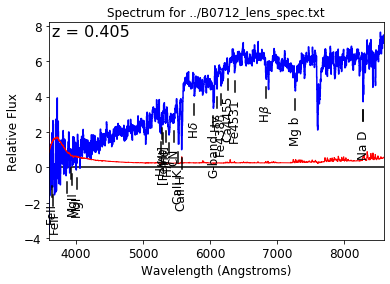

In [3]:
#%matplotlib notebook
data.plot()
data.mark_lines('abs', z=0.405)

### Checking whether the wavelength range of the tamplate spectra from the Indo-US library covers the galaxy spectra given the redshift. Here we can see the for the redshift, z=0.405, template spectra cover from $4868$ to $13304 Ang.$ So we should use only the part of the galaxy spectra where wavelength is bigger than $4868 Ang.$

In [4]:
z = 0.405
lam_temp_ini = 3465.0       
lam_temp_fin = 9469.00
lam_range_min = lam_temp_ini*(1+z)
lam_range_max = lam_temp_fin*(1+z)
print(lam_range_min)
print(lam_range_max)

4868.325
13303.945


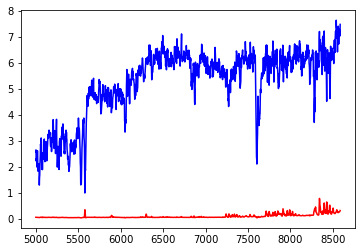

In [6]:
lamda_galaxy = data['wav'][575:]
spectra_galaxy = data['flux'][575:]
variance_spectra_galaxy = data['var'][575:]
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#lamda_galaxy.tolist().index(4999.94676193628)
plt.plot(lamda_galaxy, spectra_galaxy, 'b')
plt.plot(lamda_galaxy, variance_spectra_galaxy, 'r')

Velocity scale = 146.935776 km/s
dv = -109791.539324 


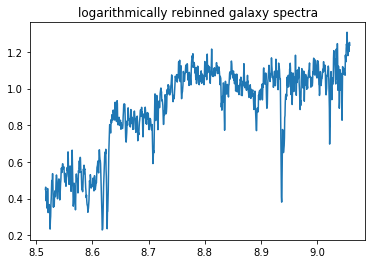

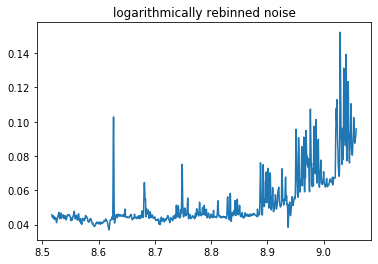

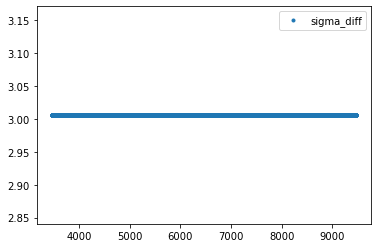

In [8]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

#constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
#plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
#plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=3.06, lam_gal=lamda_galaxy)


In [9]:
mask_region = [[(8.8324, 8.8377), (8.9312, 8.9465)], [(8.8324, 8.8377), (8.9312, 8.9465), (9.0304, 9.0577)]]
#                (8.8329, 8.8371)

In [10]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff,
                                      v=velocity_scale)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102235       216    -0.018    -0.021
chi2/DOF: 0.3896
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102235       215    -0.017    -0.027
chi2/DOF: 0.372
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850


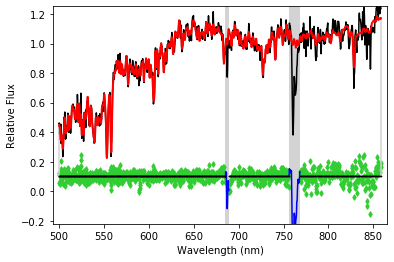

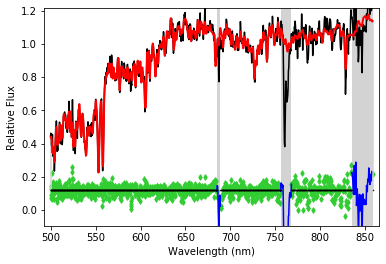

<Figure size 432x288 with 0 Axes>

In [15]:
for i, m in enumerate(mask_region):
    mask = vd.masking(m, log_lamda_galaxy)
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
              plot=True, vsyst=dv, degree=6, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()

### We have varied only degree here. We can see the associated uncertainity with the velocity dispersion from ppxf. According to ppxf package document ..." This option can be used when speed is essential, to obtain an order of magnitude estimate of the uncertainties, but we strongly recommend to run bootstrapping simulations to obtain more reliable errors. In fact these errors can be severely underestimated in the region where the penalty effect is most important (sigma < 2*velscale). These errors are meaningless unless $Chiˆ2/DOF \approx 1$. However if one assumes that the fit is good, a corrected estimate of the errors is: $error\_corr = error*sqrt(chi^2/DOF) = pp.error*sqrt(pp.chi2).$" 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102236       215    -0.018    -0.028
chi2/DOF: 0.3726
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102236       215    -0.017    -0.028
chi2/DOF: 0.3722
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102235       215    -0.017    -0.027
chi2/DOF: 0.372
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102235       215    -0.018    -0.030
chi2/DOF: 0.371
method = capfit; Jac calls: 5; Func calls: 30; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  26 / 850
degree : 7
 Best Fit:       V

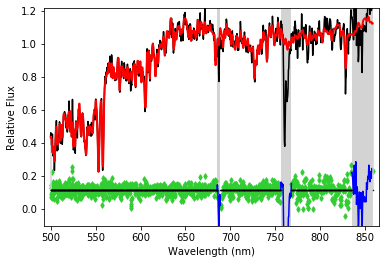

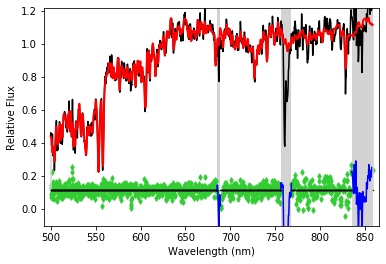

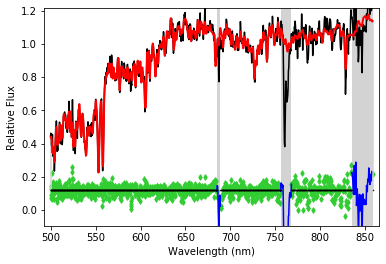

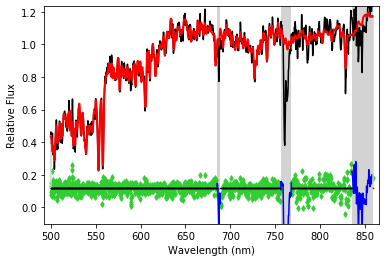

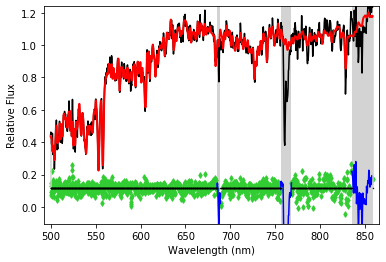

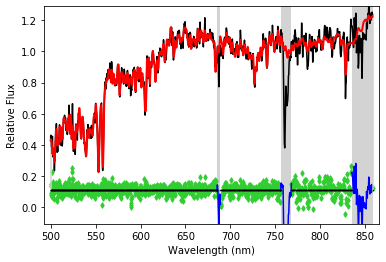

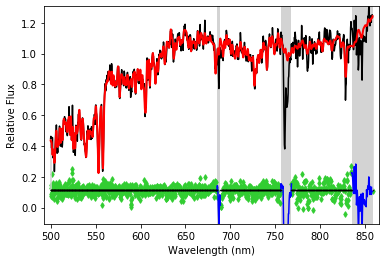

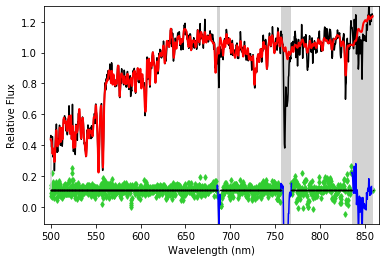

<Figure size 432x288 with 0 Axes>

In [26]:
degree = np.arange(4,12)
velocity_dispersion = np.zeros(len(degree))
error_corrected = np.zeros(len(degree))
error = np.zeros(len(degree))
mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    error[i] = pp.error[1]
    error_corrected[i] = pp.error[1]*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

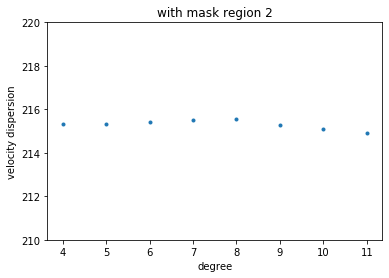

<Figure size 432x288 with 0 Axes>

In [64]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.title('with mask region 2')
plt.ylim(210, 220)
plt.figure()

<Figure size 432x288 with 0 Axes>

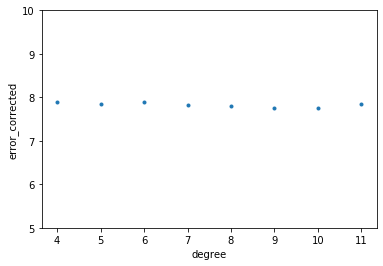

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(degree, error_corrected , '.')
plt.xlabel('degree')
plt.ylabel('error_corrected')
plt.ylim(5, 10)
plt.figure()

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102237       215    -0.016    -0.025
chi2/DOF: 0.3977
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  22 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102237       215    -0.017    -0.021
chi2/DOF: 0.3961
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  23 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102235       216    -0.018    -0.021
chi2/DOF: 0.3896
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102234       215    -0.015    -0.025
chi2/DOF: 0.3847
method = capfit; Jac calls: 4; Func calls: 26; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 850
degree : 7
 Best Fit:      

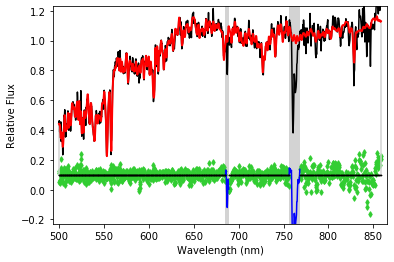

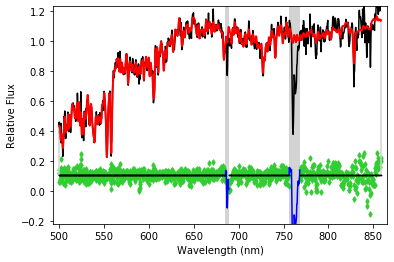

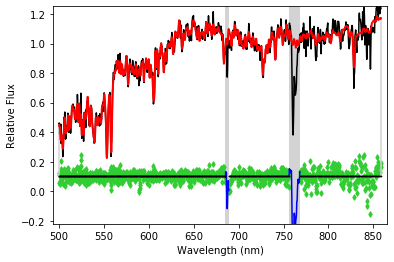

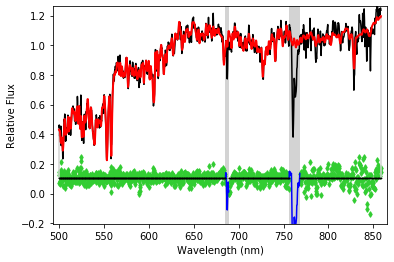

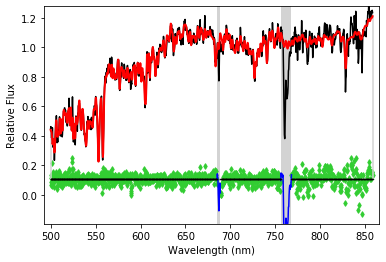

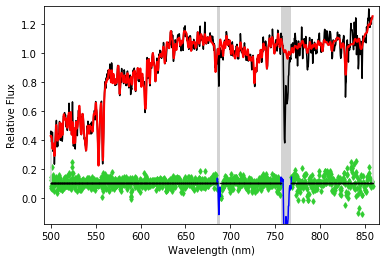

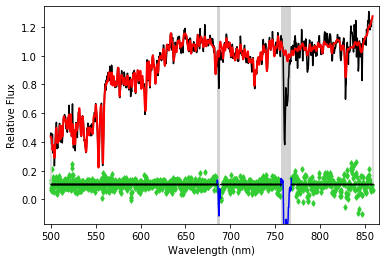

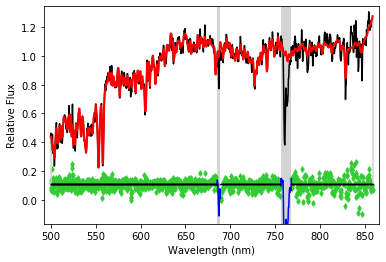

<Figure size 432x288 with 0 Axes>

In [67]:
degree = np.arange(4,12)
velocity_dispersion = np.zeros(len(degree))
error_corrected = np.zeros(len(degree))
error = np.zeros(len(degree))
mask = vd.masking(mask_region[0], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    error[i] = pp.error[1]
    error_corrected[i] = pp.error[1]*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

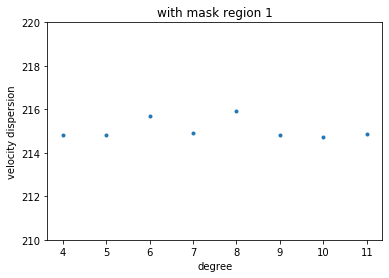

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.title('with mask region 1')
plt.ylim(210, 220)
plt.figure()

<Figure size 432x288 with 0 Axes>

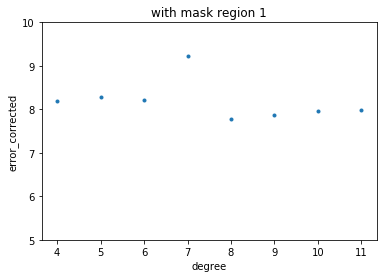

<Figure size 432x288 with 0 Axes>

In [69]:
plt.plot(degree, error_corrected , '.')
plt.xlabel('degree')
plt.ylabel('error_corrected')
plt.title('with mask region 1')
plt.ylim(5, 10)
plt.figure()

### Below we have done all the activities as above but only for the blue side of the spectra. So velocity scale, some other parameters get modified as the wavelength range changes. In this region we have not masked any part of the spectra. The velocity dispersion seems little bit lower than the fit to overall spectra.

Text(0, 0.5, 'Relative flux')

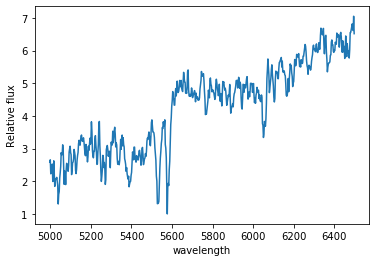

In [53]:
lamda_galaxy_bl = data['wav'][575:1190]
spectra_galaxy_bl = data['flux'][575:1190]
variance_spectra_galaxy_bl = data['var'][575:1190]
lamda_galaxy_range_bl =  [lamda_galaxy_bl[0], lamda_galaxy_bl[-1]]
plt.plot(lamda_galaxy_bl, spectra_galaxy_bl)
plt.xlabel('wavelength')
plt.ylabel('Relative flux')

Velocity scale = 146.935776 km/s
dv = -109791.539324 


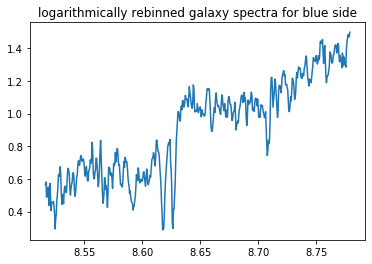

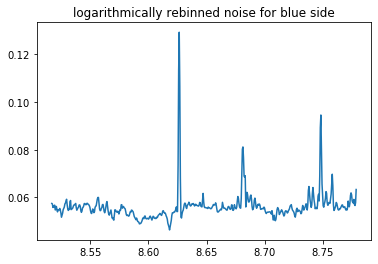

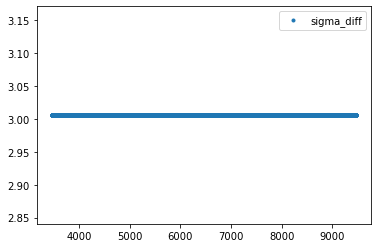

In [31]:
# Calulating velocity scale

velocity_scale_bl = vd.velocity_scale(lamda_galaxy_bl)

# Calculating the parameter 'dv'

dv_bl = vd.wav_dev(lamda_galaxy_bl[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal_bl = np.median(spectra_galaxy_bl)       # median of the spectra_galaxy
spectra_galaxy_normalized_bl = spectra_galaxy_bl / median_spectra_gal_bl
spectra_galaxy_rebinned_bl, log_lamda_galaxy_bl, v_bl = util.log_rebin(lamda_galaxy_range_bl,
                                                    spectra_galaxy_normalized_bl, velscale=velocity_scale_bl)
plt.plot(log_lamda_galaxy_bl, spectra_galaxy_rebinned_bl)
plt.title('logarithmically rebinned galaxy spectra for blue side')
plt.show()

## Noise

sigma_galaxy_spectra_bl = np.sqrt(variance_spectra_galaxy_bl) 
noise_bl = sigma_galaxy_spectra_bl / median_spectra_gal_bl

#constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
noise_rebinned_bl, log_lamda_noise_bl, velo_scale_bl = util.log_rebin(lamda_galaxy_range_bl, noise_bl,
                                                         velscale=velocity_scale_bl)

plt.plot(log_lamda_noise_bl, noise_rebinned_bl)
plt.title('logarithmically rebinned noise for blue side')
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
#plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
#plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff_bl = vd.gen_sigma_diff(sig_ins=3.06, lam_gal=lamda_galaxy_bl)



In [32]:
templates_bl = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff_bl,
                                      v=velocity_scale_bl)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102227       209    -0.020    -0.012
chi2/DOF: 0.344
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  20 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102227       209    -0.019    -0.010
chi2/DOF: 0.3439
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  20 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102227       209    -0.018    -0.008
chi2/DOF: 0.3434
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  20 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102227       209    -0.018    -0.010
chi2/DOF: 0.3434
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  21 / 850
degree : 7
 Best Fit:       

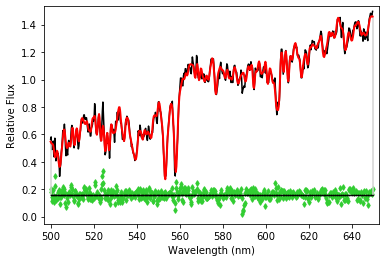

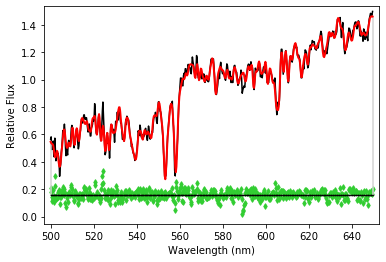

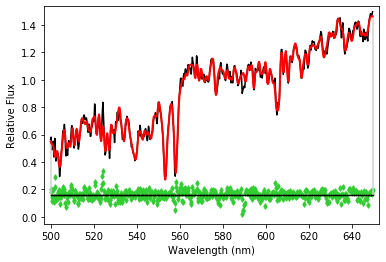

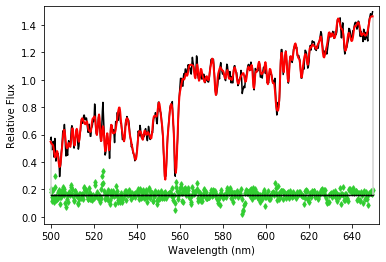

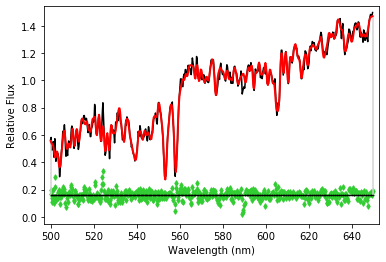

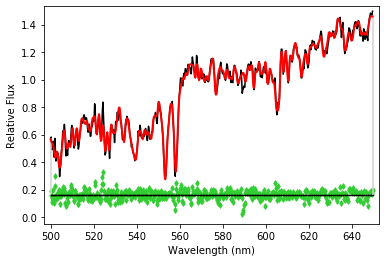

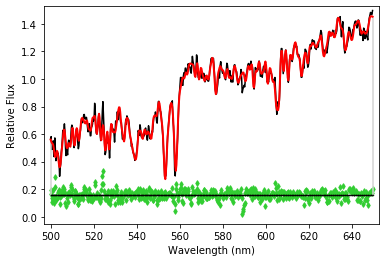

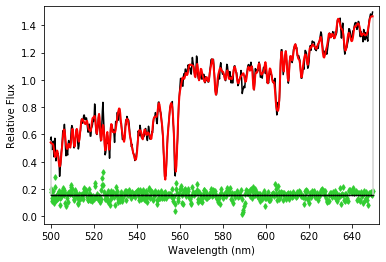

<Figure size 432x288 with 0 Axes>

In [33]:
degree = np.arange(4,12)
velocity_dispersion_bl = np.zeros(len(degree))
error_corrected_bl = np.zeros(len(degree))
error_bl = np.zeros(len(degree))
#mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates_bl, spectra_galaxy_rebinned_bl, noise_rebinned_bl, velocity_scale_bl, start, 
              moments=4, plot=True, degree=degree[i], vsyst=dv_bl, lam=np.exp(log_lamda_galaxy_bl))
    velocity_dispersion_bl[i] = pp.sol[1]
    error_bl[i] = pp.error[1]
    error_corrected_bl[i] = pp.error[1]*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

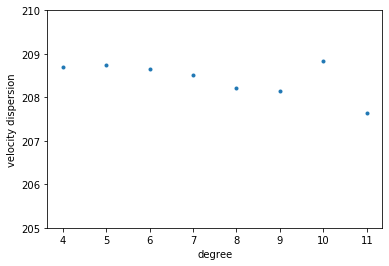

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(degree, velocity_dispersion_bl, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.ylim(205, 210)
plt.figure()

<Figure size 432x288 with 0 Axes>

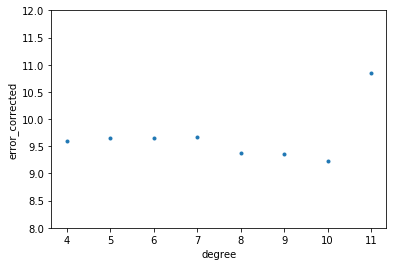

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(degree, error_corrected_bl , '.')
plt.xlabel('degree')
plt.ylabel('error_corrected')
plt.ylim(8, 12)
plt.figure()

### Below we have done all the activities as above but only for the red side of the spectra. So velocity scale, some other parameters get modified as the wavelength range changes. In this region we have masked some part of the spectra. The velocity dispersion seems higher than the fit to overall spectra.

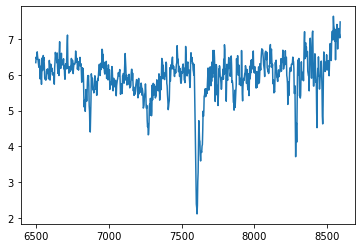

In [40]:
lamda_galaxy_rd = data['wav'][1190:]
spectra_galaxy_rd = data['flux'][1190:]
variance_spectra_galaxy_rd = data['var'][1190:]
lamda_galaxy_range_rd =  [lamda_galaxy_rd[0], lamda_galaxy_rd[-1]]
plt.plot(lamda_galaxy_rd, spectra_galaxy_rd)

Velocity scale = 112.520859 km/s
dv = -188584.308838 


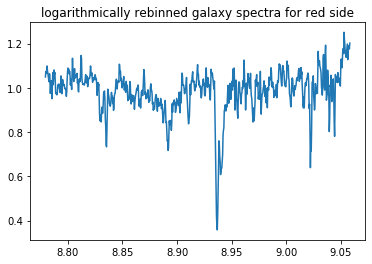

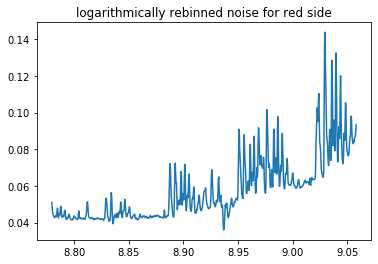

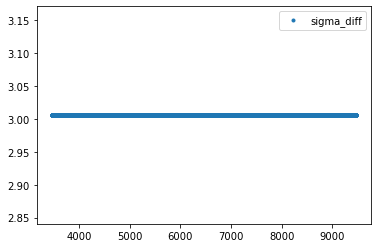

In [42]:
# Calulating velocity scale

velocity_scale_rd = vd.velocity_scale(lamda_galaxy_rd)

# Calculating the parameter 'dv'

dv_rd = vd.wav_dev(lamda_galaxy_rd[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal_rd = np.median(spectra_galaxy_rd)       # median of the spectra_galaxy
spectra_galaxy_normalized_rd = spectra_galaxy_rd / median_spectra_gal_rd
spectra_galaxy_rebinned_rd, log_lamda_galaxy_rd, v_rd = util.log_rebin(lamda_galaxy_range_rd,
                                                    spectra_galaxy_normalized_rd, velscale=velocity_scale_rd)
plt.plot(log_lamda_galaxy_rd, spectra_galaxy_rebinned_rd)
plt.title('logarithmically rebinned galaxy spectra for red side')
plt.show()

## Noise

sigma_galaxy_spectra_rd = np.sqrt(variance_spectra_galaxy_rd) 
noise_rd = sigma_galaxy_spectra_rd / median_spectra_gal_rd

#constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
noise_rebinned_rd, log_lamda_noise_rd, velo_scale_rd = util.log_rebin(lamda_galaxy_range_rd, noise_rd,
                                                         velscale=velocity_scale_rd)

plt.plot(log_lamda_noise_rd, noise_rebinned_rd)
plt.title('logarithmically rebinned noise for red side')
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
#plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
#plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff_rd = vd.gen_sigma_diff(sig_ins=3.06, lam_gal=lamda_galaxy_rd)



In [43]:
templates_rd = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff_rd,
                                      v=velocity_scale_rd)

In [44]:
mask_region = [[(8.8324, 8.8377), (8.9312, 8.9465)], [(8.8324, 8.8377), (8.9312, 8.9465), (9.0304, 9.0577)]]
#                (8.8329, 8.8371)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102241       226    -0.051    -0.040
chi2/DOF: 0.4119
method = capfit; Jac calls: 6; Func calls: 32; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102240       231    -0.034    -0.038
chi2/DOF: 0.3955
method = capfit; Jac calls: 6; Func calls: 35; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850


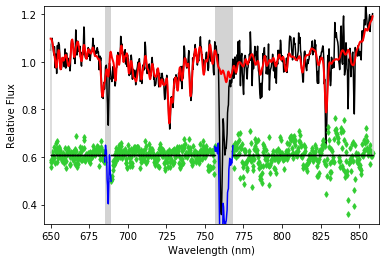

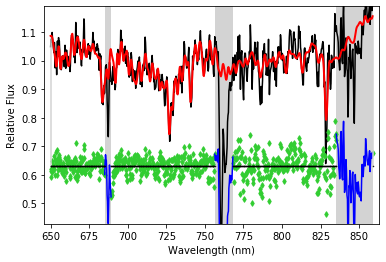

<Figure size 432x288 with 0 Axes>

In [45]:
for i, m in enumerate(mask_region):
    mask = vd.masking(m, log_lamda_galaxy_rd)
    pp = ppxf(templates_rd, spectra_galaxy_rebinned_rd, noise_rebinned_rd, velocity_scale_rd, start, 
              moments=4, plot=True, vsyst=dv_rd, degree=6, mask=mask, lam=np.exp(log_lamda_galaxy_rd))
    plt.figure()

### Varying degree for two sets of mask region

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102239       233    -0.032    -0.018
chi2/DOF: 0.4302
method = capfit; Jac calls: 6; Func calls: 34; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  20 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102244       230    -0.025    -0.026
chi2/DOF: 0.4241
method = capfit; Jac calls: 6; Func calls: 32; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  19 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102241       226    -0.051    -0.040
chi2/DOF: 0.4119
method = capfit; Jac calls: 6; Func calls: 32; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102244       235    -0.035    -0.024
chi2/DOF: 0.3956
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  22 / 850
degree : 7
 Best Fit:      

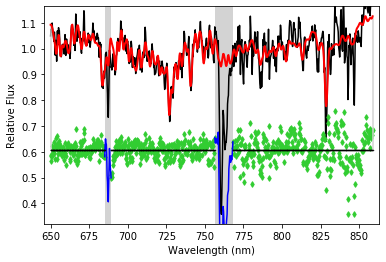

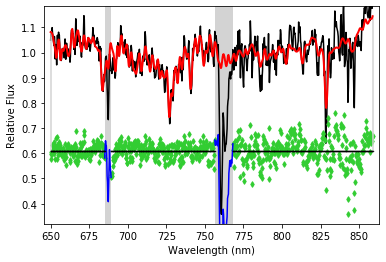

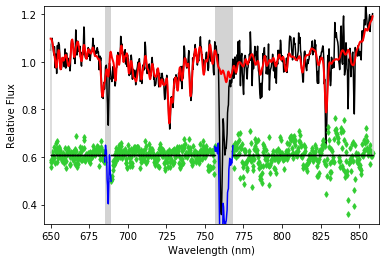

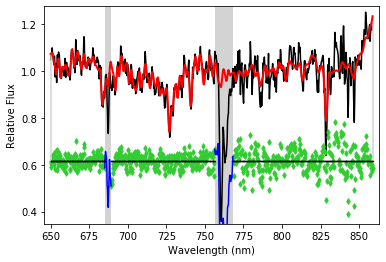

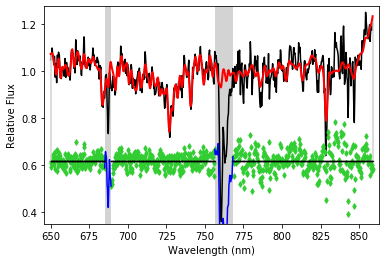

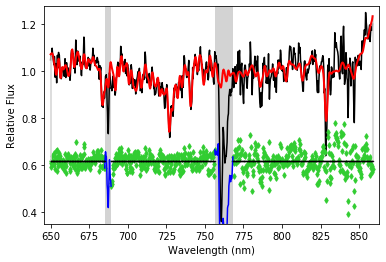

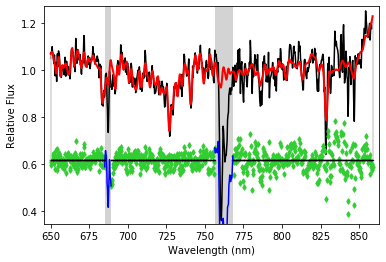

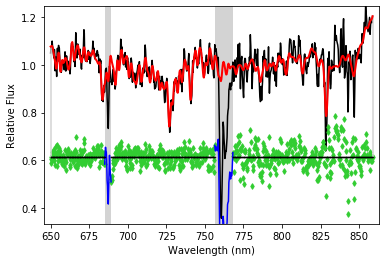

<Figure size 432x288 with 0 Axes>

In [57]:
degree = np.arange(4,12)
velocity_dispersion_rd = np.zeros(len(degree))
error_corrected_rd = np.zeros(len(degree))
error_rd = np.zeros(len(degree))
mask = vd.masking(mask_region[0], log_lamda_galaxy_rd)
for i in range(len(degree)):
    pp = ppxf(templates_rd, spectra_galaxy_rebinned_rd, noise_rebinned_rd, velocity_scale_rd, start, 
              moments=4, plot=True, degree=degree[i], vsyst=dv_rd, mask=mask, lam=np.exp(log_lamda_galaxy_rd))
    velocity_dispersion_rd[i] = pp.sol[1]
    error_rd[i] = pp.error[1]
    error_corrected_rd[i] = pp.error[1]*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

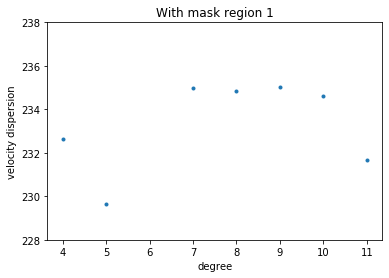

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(degree, velocity_dispersion_rd, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.title('With mask region 1')
plt.ylim(228, 238)
plt.figure()

<Figure size 432x288 with 0 Axes>

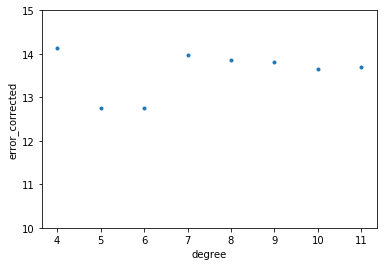

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(degree, error_corrected_rd , '.')
plt.xlabel('degree')
plt.ylabel('error_corrected')
plt.ylim(10, 15)
plt.figure()

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102240       233    -0.028    -0.030
chi2/DOF: 0.3972
method = capfit; Jac calls: 6; Func calls: 35; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102240       233    -0.027    -0.032
chi2/DOF: 0.397
method = capfit; Jac calls: 6; Func calls: 35; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 850
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102240       231    -0.034    -0.038
chi2/DOF: 0.3955
method = capfit; Jac calls: 6; Func calls: 35; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850
degree : 6
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102244       235    -0.034    -0.015
chi2/DOF: 0.3862
method = capfit; Jac calls: 5; Func calls: 27; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  17 / 850
degree : 7
 Best Fit:       

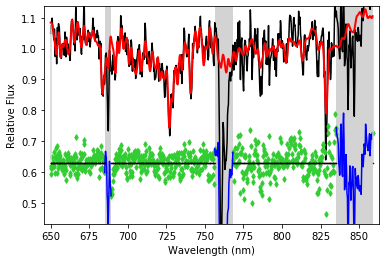

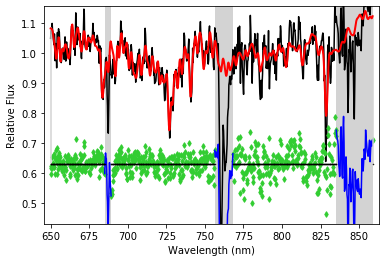

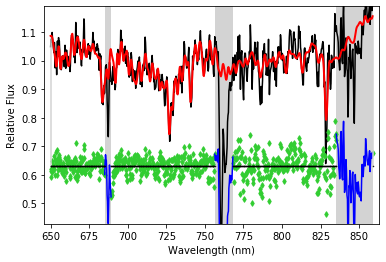

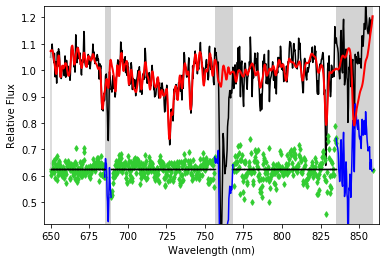

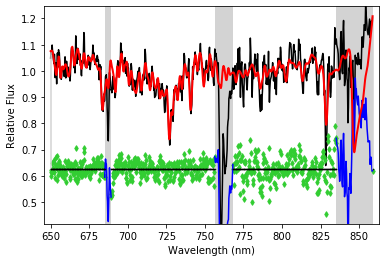

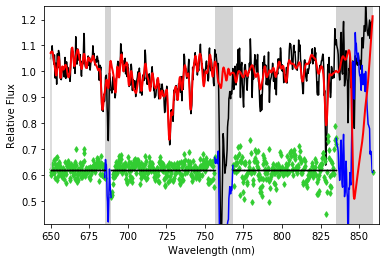

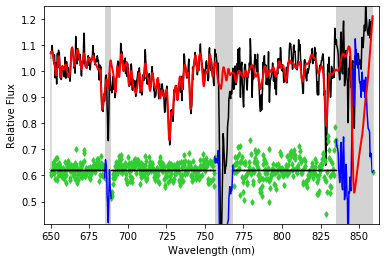

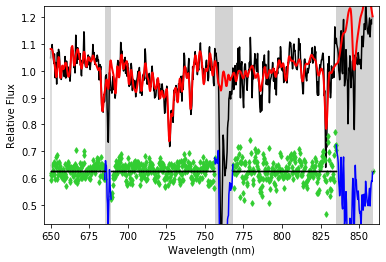

<Figure size 432x288 with 0 Axes>

In [61]:
degree = np.arange(4,12)
velocity_dispersion_rd = np.zeros(len(degree))
error_corrected_rd = np.zeros(len(degree))
error_rd = np.zeros(len(degree))
mask = vd.masking(mask_region[1], log_lamda_galaxy_rd)
for i in range(len(degree)):
    pp = ppxf(templates_rd, spectra_galaxy_rebinned_rd, noise_rebinned_rd, velocity_scale_rd, start, 
              moments=4, plot=True, degree=degree[i], vsyst=dv_rd, mask=mask, lam=np.exp(log_lamda_galaxy_rd))
    velocity_dispersion_rd[i] = pp.sol[1]
    error_rd[i] = pp.error[1]
    error_corrected_rd[i] = pp.error[1]*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

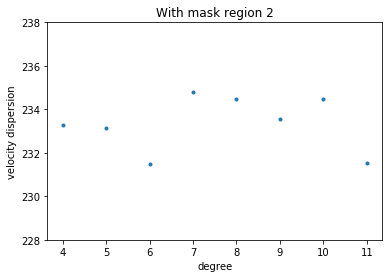

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(degree, velocity_dispersion_rd, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.title('With mask region 2')
plt.ylim(228, 238)
plt.figure()

<Figure size 432x288 with 0 Axes>

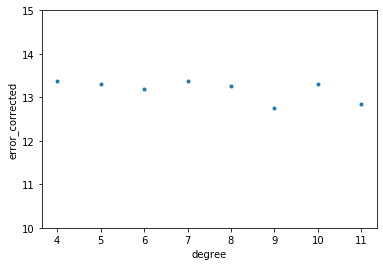

<Figure size 432x288 with 0 Axes>

In [63]:
plt.plot(degree, error_corrected_rd , '.')
plt.xlabel('degree')
plt.ylabel('error_corrected')
plt.ylim(10, 15)
plt.figure()